In [1]:
#Import relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import scipy as sp
from scipy import interpolate
from scipy import signal
import scipy.optimize as opt

In [2]:
#Define routines to extract spectra of moons from individual cubes

def twoD_bg(xy, offset, slopex,slopey,quadx,quady,quadxy, cubx,cubxxy,cubxyy,cuby):
    x, y = xy  
    g = offset+slopex*x+slopey*y+quadx*x**2+quady*y**2+quadxy*x*y+cubx*x**3+cubxxy*x**2*y+cubxyy*x*y**2+cuby*y**3
    return g.ravel()

def psffact(waves):
    image_file='jw01128-SNAP2/jw01128-o002_t016_nirspec_prism-clear_s3d.fits'
    hdul = fits.open(image_file)
    hdr=hdul[1].header
    #print(hdr)
    area=hdr['PIXAR_SR']
    nwave=hdr['NAXIS3']
    wave0=hdr['CRVAL3']
    dwave=hdr['CDELT3']
    wavesn=np.linspace(wave0,wave0+nwave*dwave,nwave)
    qub = fits.getdata(image_file, ext=1).astype(float)
    specsx=np.sum(np.sum(qub[:,27:30,27:30],axis=1),axis=1)
    specsn=specsx-specsx
    for i in range(len(specsn)):
        dat=qub[i,:,:]
        foo=(dat<2e4) & (dat>0)
        m=np.median(dat[foo])
        specsn[i]=np.nansum(dat[foo]-m)
        specsx[i]=np.nansum(dat[27:30,27:30]-m)
    rfact=specsx/specsn
    foobr=(rfact>.6) & (np.abs(wavesn-1.2)>.25)
    f,e,d,c,a,b,m=np.polyfit(wavesn[foobr],rfact[foobr],6)
    rfit=m+b*wavesn+a*wavesn**2+c*wavesn**3+d*wavesn**4+e*wavesn**5+f*wavesn**6
    foox=(np.abs(rfact-rfit)<.002*wavesn) & (np.abs(wavesn-1.2)>.25)
    f,e,d,c,b,a,m=np.polyfit(wavesn[foox],rfact[foox],6)
    rfit=m+a*wavesn+b*wavesn**2+c*wavesn**3+d*wavesn**4+e*wavesn**5+f*wavesn**6
    interp_func = interpolate.UnivariateSpline(wavesn, rfit)
    out = interp_func(waves)
    return out

    out=scipy.interpolate.interp1d
        
def objmod (slon,slat,clon,clat,a,b,c,k): 
    theta=np.pi/180*np.array(range(181)) 
    phi=np.pi/180*np.array(range(361)) 
    mat=np.array(np.ones((361,181),float)) 
    thx=mat*1.0
    phix=mat*1.0
    for i in range(361):
        for j in range(181):
            thx[i,j]=np.pi*j/180
            phix[i,j]=np.pi*i/180 
    areaf=np.sqrt(a**2*b**2*np.cos(thx)**2+
                  c**2*(b**2*np.cos(phix)**2+a**2*np.sin(phix)**2)*np.sin(thx)**2)
    rf=np.sqrt(areaf)
    xf=np.sin(thx)*np.cos(phix)/a
    yf=np.sin(thx)*np.sin(phix)/b
    zf=np.cos(thx)/c
    nx=xf/np.sqrt(xf**2+yf**2+zf**2)
    ny=yf/np.sqrt(xf**2+yf**2+zf**2)
    nz=zf/np.sqrt(xf**2+yf**2+zf**2)
    sln=slon*np.pi/180
    slt=(90-slat)*np.pi/180
    cln=clon*np.pi/180
    clt=(90-clat)*np.pi/180 
    cosi=nx*np.sin(slt)*np.cos(sln)+ny*np.sin(slt)*np.sin(sln)+nz*np.cos(slt) 
    cose=nx*np.sin(clt)*np.cos(cln)+ny*np.sin(clt)*np.sin(cln)+nz*np.cos(clt) 
    cosi=.5*(cosi+abs(cosi))
    cose=.5*(cose+abs(cose))
    bright=cosi**k*cose**(1-k) 
    brfact=bright*np.sin(thx)*areaf*cose*np.pi/180*np.pi/180 
    pred=np.sum(brfact)
    return pred

def sourcespec(qub, xc, yc,rmin,rmax):
    nspec=np.shape(qub)[0]
    ny=np.shape(qub)[1]
    nx=np.shape(qub)[2]
    y=np.linspace(0,ny-1,ny)
    x=np.linspace(0,nx-1,nx)
    x,y=np.meshgrid(x,y)
    spec=np.zeros(nspec)
    errs=np.zeros(nspec)
    for i in range(nspec):
        initial_guess=(0,0,0,0,0,0,0,0,0,0)
        dat=qub[i,:,:]
        foo=(np.isnan(dat)==0) & (np.abs(x-xc)<rmax) & (np.abs(y-yc)<rmax)
        foo[yc-rmin:yc+rmin+1,xc-rmin:xc+rmin+1]=False
        if(np.count_nonzero(foo)>10):
            popt, pcov = opt.curve_fit(twoD_bg, (x[foo], y[foo]),dat[foo], p0=initial_guess)
            bgdat=dat-twoD_bg((x,y),popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8],popt[9]).reshape(ny,nx)
            spec[i]=np.nanmean(bgdat[yc-rmin:yc+rmin+1,xc-rmin:xc+rmin+1])*(2*rmin+1)**2
            errs[i]=np.std(bgdat[foo])*(2*rmin+1) 
    return(spec,errs)

def nirspecproc(image_file, moon, dither,xc, yc,rmin,rmax,tit,vmax):
    #Sundist, dist and size in km
    hdul = fits.open(image_file)
    hdr=hdul[1].header
    #print(hdr)
    area=hdr['PIXAR_SR']
    nwave=hdr['NAXIS3']
    wave0=hdr['CRVAL3']
    dwave=hdr['CDELT3']
    waves=np.linspace(wave0,wave0+nwave*dwave,nwave)
    qub = fits.getdata(image_file, ext=1).astype(float)
    foo=(waves>1) & (waves<2)
    plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),
            cmap='gray', vmin=-vmax, vmax=vmax, origin='lower')
    #plt.grid(None)
    plt.title(tit)
    ny=np.shape(qub)[1]
    nx=np.shape(qub)[2]
    y=np.linspace(0,ny-1,ny)
    x=np.linspace(0,nx-1,nx)
    x,y=np.meshgrid(x,y)
    zones=(x-y)*0
    foo=((np.abs(x-xc)<rmax) & (np.abs(y-yc)<rmax))
    foo[yc-rmin:yc+rmin+1,xc-rmin:xc+rmin+1]=False
    zones[foo]=0.5
    zones[yc-rmin:yc+rmin+1,xc-rmin:xc+rmin+1]=1
    plt.plot([xc+rmin+.5,xc+rmin+.5,xc-rmin-.5,xc-rmin-.5,xc+rmin+.5],
             [yc-rmin-.5,yc+rmin+.5,yc+rmin+.5,yc-rmin-.5,yc-rmin-.5], 'g')
    plt.plot([xc+rmax-.5,xc+rmax-.5,xc-rmax+.5,xc-rmax+.5,xc+rmax-.5],
             [yc-rmax+.5,yc+rmax-.5,yc+rmax-.5,yc-rmax+.5,yc-rmax+.5], 'c')
  
    plt.show()
    image_file = get_pkg_data_filename(
    "solar_spec.fits")
    hdul = fits.open(image_file)
    dat = fits.getdata(image_file, ext=1)
    dat.dtype
    wave=dat['wavelength'].astype(float)
    wavex=wave/1e4
    flux=dat['flux'].astype(float)
    fr=interpolate.interp1d(wavex,flux, fill_value='extrapolate')
    #flux in this file is in erg/s/cm^2/Angstrom
    #Jy=1e-23 erg/s/cm^2/Hz
    #MJy=1e-17 erg/s/cm^2/Hz
    # so 
    # 2022-11-08 (pandora, epimetheus): Sun 1473e6 km JWST 1460e6
    # 2022-11-10 (telesto): Sun 1473e6 km JWST 1465e6
    # 2023-06-20 (pallene): Sun 1465e6 km JWST 1402e6
    #covert to F
    if moon == 'Pallene':
        sundist=1465e6
        dist=1402e6
        size=2.23
        a=2.88
        b=2.08
        c=1.84
        phasex=5.6
        if dither==1:
            slat=9.8
            slon=85.5
            clat=7.3
            clon=80.5
        if dither==2:
            slat=9.8
            slon=88.5
            clat=7.3
            clon=83.5
    if moon == 'Pandora':
        sundist=1473e6
        dist=1460e6
        size=40.
        a=51.5
        b=39.5
        c=31.5
        if dither==1:
            slat=12.7
            slon=254.5
            clat=15.2
            clon=259.9
        if dither==2:
            slat=12.7
            slon=256.5
            clat=15.2
            clon=261.9
    if moon == 'Epimetheus':
        sundist=1473e6
        dist=1460e6
        size=58.6
        a=64.8
        b=58.1
        c=53.5
        phasex=5.9
        if dither==1:
            slat=12.6
            slon=244.9
            clat=15.2
            clon=250.4
        if dither==2:
            slat=12.6
            slon=246.8
            clat=15.2
            clon=252.2
    if moon == 'Telesto':
        sundist=1473e6
        dist=1465e6
        size=12.3
        a=16.6
        b=11.7
        c=9.6
        phasex=5.8
        if dither==1:
            slat=12.7
            slon=258.5
            clat=15.2
            clon=264.0
        if dither==2:
            slat=12.7
            slon=259.5
            clat=15.2
            clon=264.8
    solflux=fr(waves)*waves**2/(sundist/1.496e8)**2/3/np.pi*1e7
    #calfact=1/solflux*dist**2/np.pi/size**2
    areax=objmod (slon,slat,clon,clat,a,b,c,1.0)
    calfact=1/solflux*dist**2/areax
    specjx,errjx=sourcespec(qub, xc,yc,rmin,rmax)
    specj=specjx/psffact(waves)
    errj=errjx/psffact(waves)
    spec=specj*calfact
    err=errj*calfact
    foo=(waves>1.3)
    specp=np.zeros(int(nwave/10))
    spece=np.zeros(int(nwave/10))
    wavep=np.zeros(int(nwave/10))
    for i in range(int(nwave/10)):
        dat=spec[i*10:(i+1)*10]
        wavep[i]=np.mean(waves[i*10:(i+1)*10])
        m=np.nanmedian(dat)
        s=np.nanstd(dat)
        foox=(np.abs(dat-m) <2*s) & ((dat)<2) & (dat>-0.5)
        if (np.count_nonzero(foox)>3):
                specp[i]=np.nanmean(dat[foox])
                spece[i]=np.nanstd(dat[foox])/np.sqrt(np.count_nonzero(foox)-1)
    plt.figure(figsize=[20,10])
    #foo=(waves>1.3)
    #foop=(wavep>1.3) & (spece>0)
    foo=(waves>0)
    foop=(wavep>0) & (spece>0)
    plt.rcParams['font.size'] = 24
    plt.plot(waves[foo],spec[foo], 'bo')
    plt.plot(wavep[foop],specp[foop]+spece[foop],'tab:gray', linewidth=4)
    plt.plot(wavep[foop],specp[foop]-spece[foop],'tab:gray', linewidth=4)
    plt.plot(wavep[foop],specp[foop],'k', linewidth=4)
    plt.ylabel('Brightness Coefficient')
    plt.xlabel('Wavelength (microns)')
    plt.ylim([-.1,1.1])
    plt.xlim([0,5])
    plt.title(tit)
    plt.show()
    plt.rcParams['font.size'] = 12
    return waves,specj,spec, wavep,specp, errj, err



/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


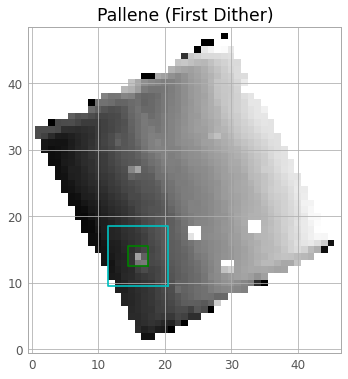

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


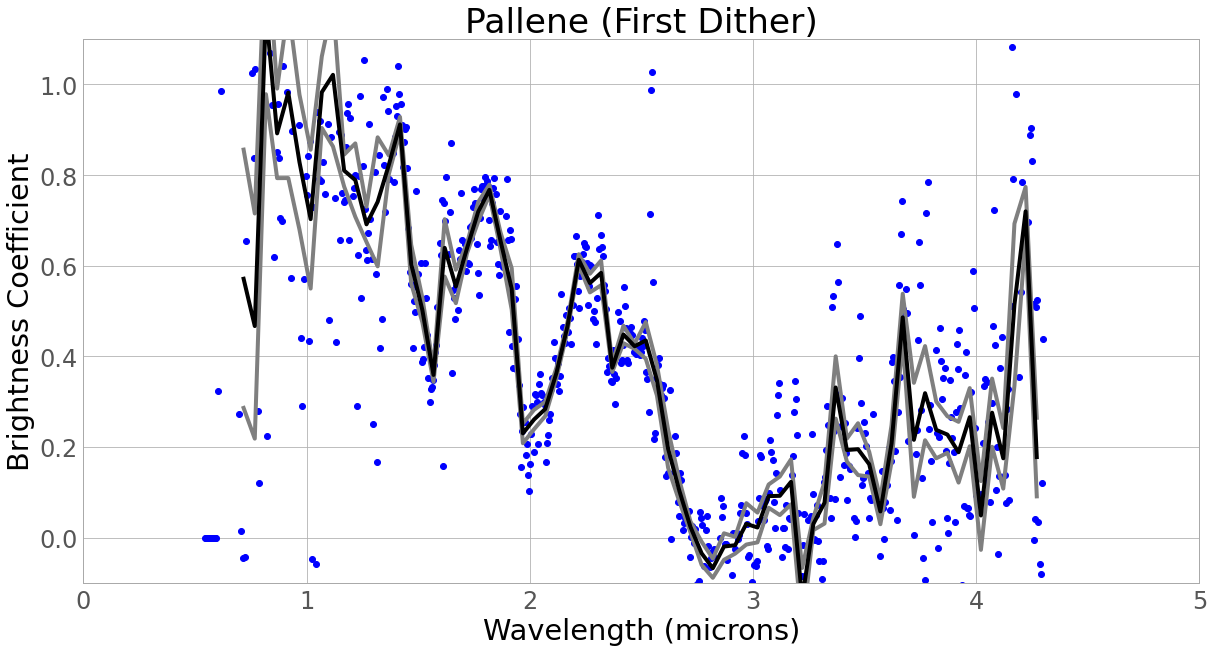

In [3]:
#Apply above routines to obtain spectra of moons from relevant cubes. 
#Also generates various panels of Figure 5

wavepl1,specjpl1, specpl1,waveppl1,specppl1,errjpl1,errpl1=nirspecproc("jw01247/2023-06-20_Pallene/radec_frame/stage3/d1/Level3_01_prism-clear_s3d.fits", 
            'Pallene',1, 16, 14, 1,5,'Pallene (First Dither)', 1e-12)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


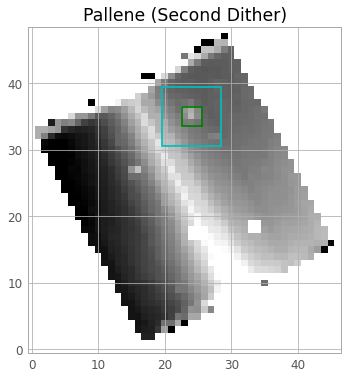

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


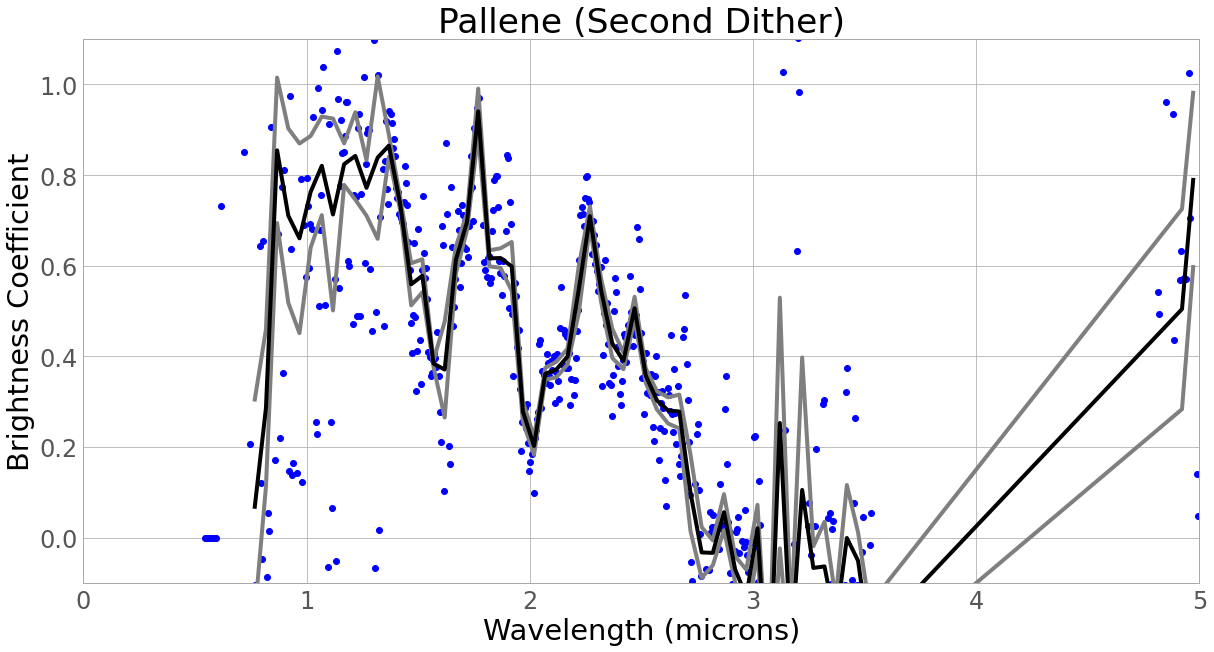

In [4]:
wavepl2,specjpl2, specpl2,waveppl2,specppl2,errjpl2,errpl2=nirspecproc("jw01247/2023-06-20_Pallene/radec_frame/stage3/d2/Level3_01_prism-clear_s3d.fits", 
            'Pallene', 2,24, 35, 1,5,'Pallene (Second Dither)', 1e-12)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


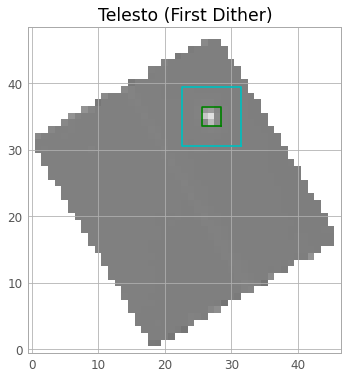

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


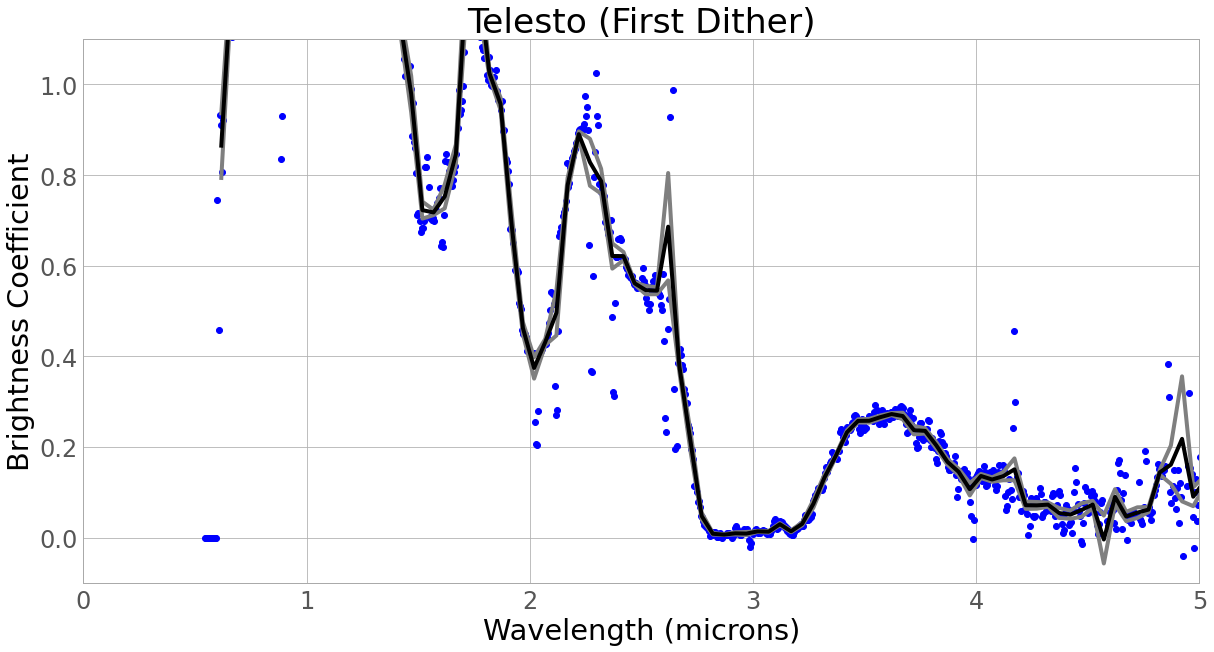

In [5]:
wavetl1,specjtl1, spectl1,waveptl1,specptl1,errjtl1,errtl1=nirspecproc("jw01247/Telesto-2/stage3/d1/Level3_prism-clear_s3d.fits", 
            'Telesto', 1,27, 35, 1,5,'Telesto (First Dither)', 4e-11)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


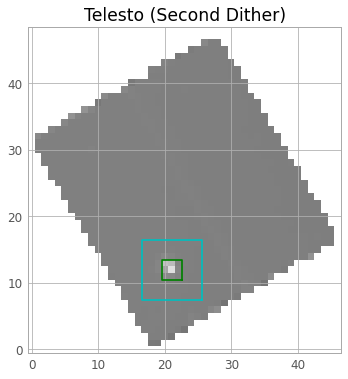

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


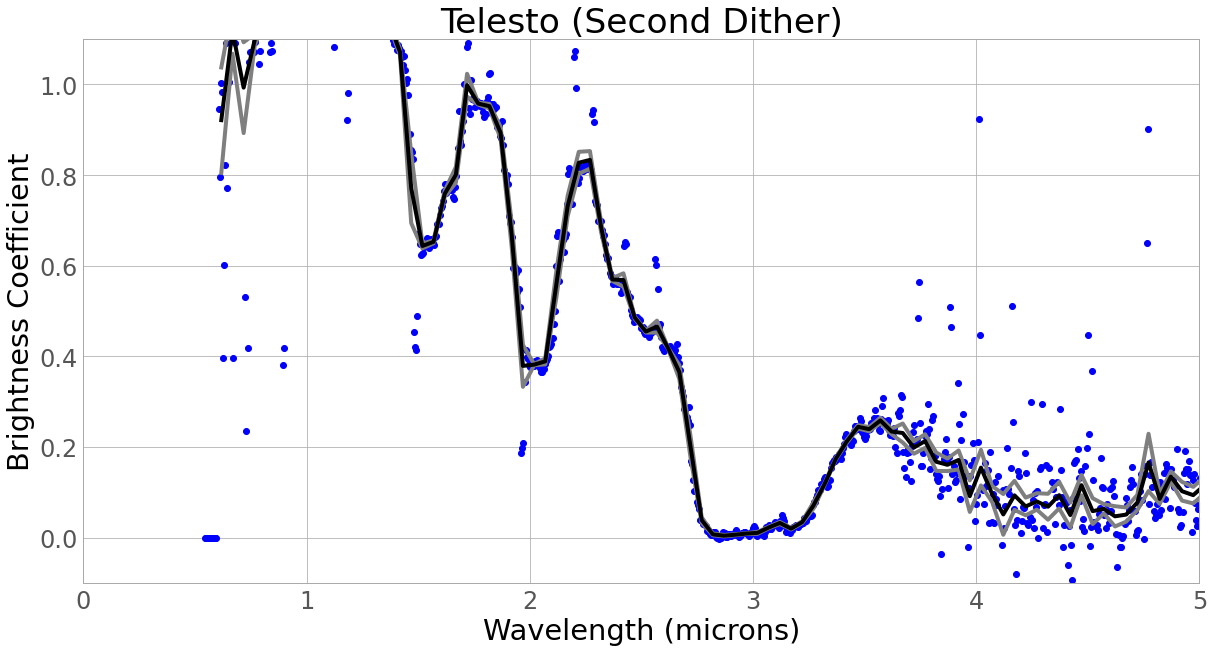

In [6]:
wavetl2,specjtl2, spectl2,waveptl2,specptl2,errjtl2,errtl2=nirspecproc("jw01247/Telesto-2/stage3/d2/Level3_prism-clear_s3d.fits", 
            'Telesto',2,21,12, 1,5,'Telesto (Second Dither)', 4e-11)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


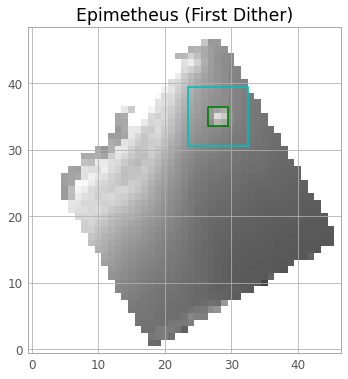

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


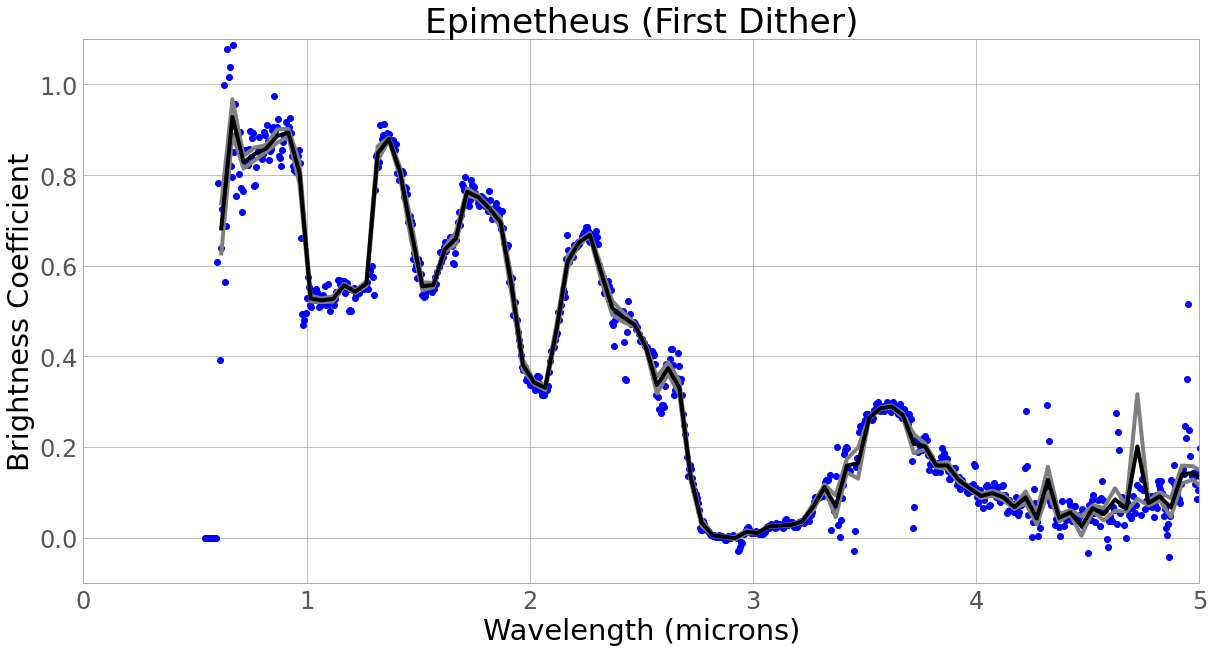

In [7]:
waveep1,specjep1, specep1,wavepep1,specpep1, errjep1,errep1=nirspecproc("jw01247/Epimetheus-2/stage3/d1/Level3_prism-clear_s3d.fits", 
            'Epimetheus', 1, 28, 35, 1,5,'Epimetheus (First Dither)', 5e-10)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


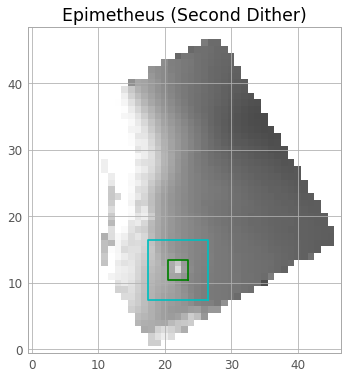

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


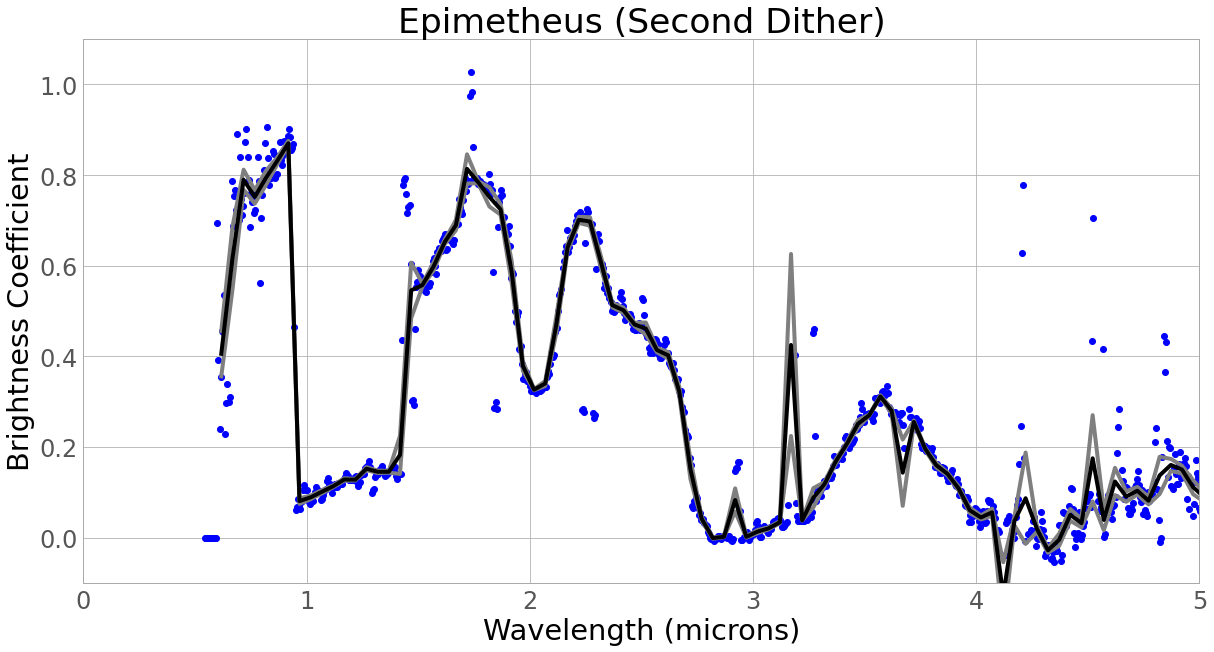

In [8]:
waveep2,specjep2, specep2,wavepep2,specpep2,errjep2,errep2=nirspecproc("jw01247/Epimetheus-2/stage3/d2/Level3_prism-clear_s3d.fits", 
            'Epimetheus', 2, 22, 12, 1,5,'Epimetheus (Second Dither)', 5e-10)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


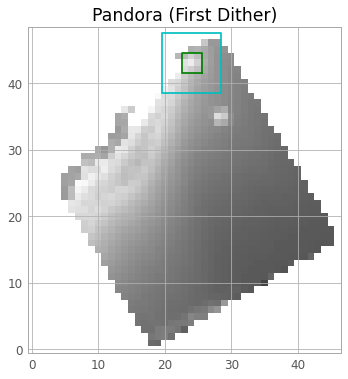

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


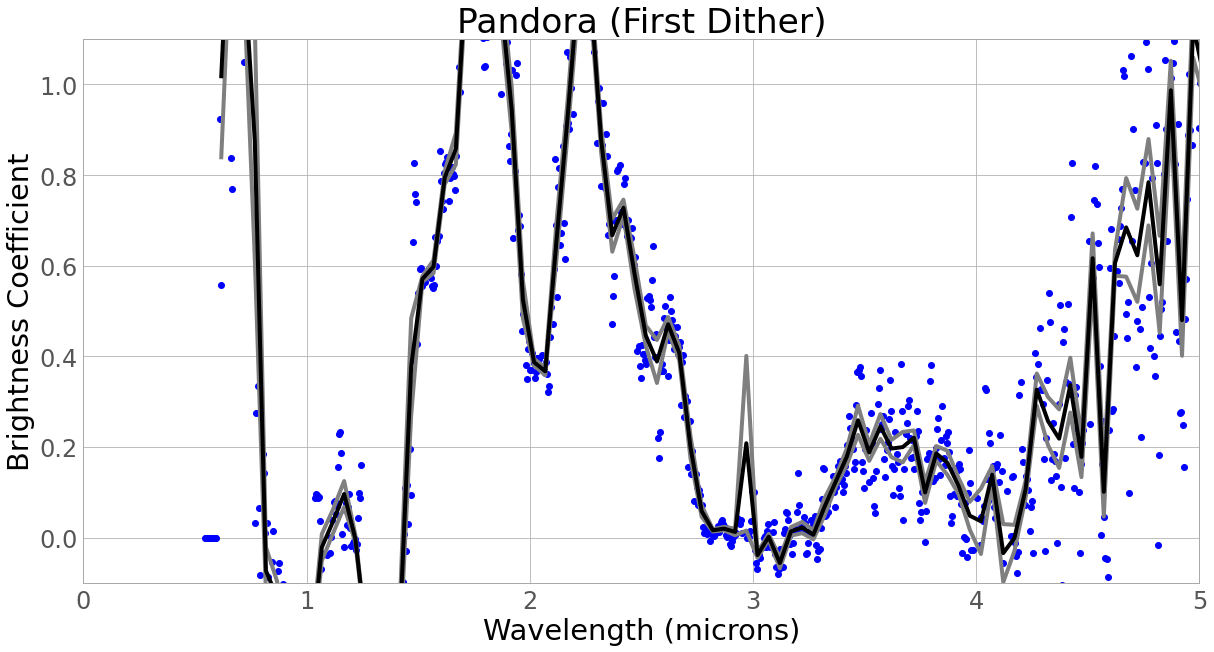

In [9]:
wavepd1,specjpd1, specpd1,waveppd1,specppd1, errjpd1,errpd1=nirspecproc("jw01247/Epimetheus-2/stage3/d1/Level3_prism-clear_s3d.fits", 
            'Pandora', 1, 24, 43,1,5,'Pandora (First Dither)', 5e-10)
#Modified to be more consistent with others

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:105: RuntimeWarning: Mean of empty slice
  plt.imshow((np.nanmean(qub[foo,:,:], axis=0)-np.nanmedian(np.nanmean(qub[foo,:,:], axis=0))),


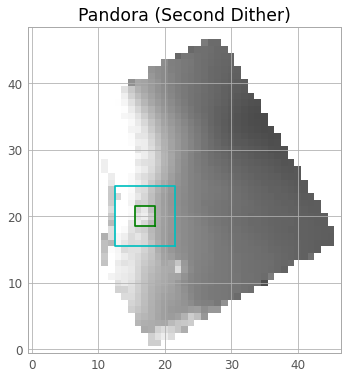

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/164923143.py:27: RuntimeWarning: invalid value encountered in true_divide
  rfact=specsx/specsn


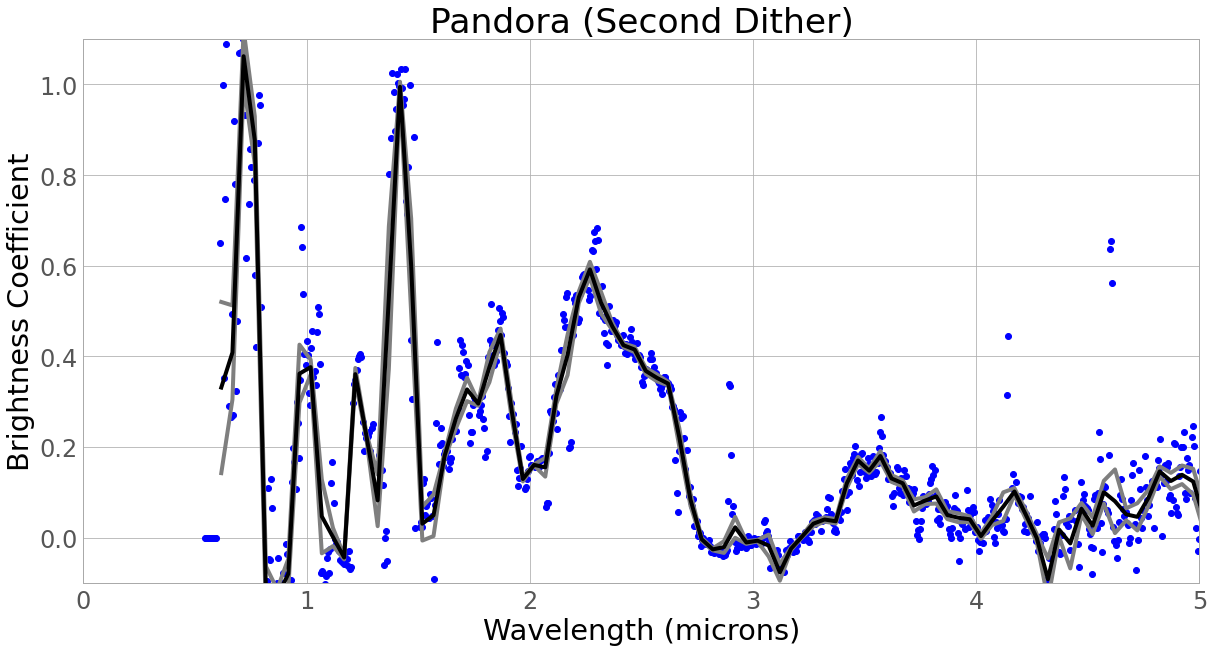

In [10]:
wavepd2,specjpd2, specpd2,waveppd2,specppd2, errjpd2,errpd2=nirspecproc("jw01247/Epimetheus-2/stage3/d2/Level3_prism-clear_s3d.fits", 
            'Pandora', 2, 17,20, 1,5,'Pandora (Second Dither)', 5e-10)

In [11]:
#Define routine for extracting spectral parameters from the above spectra

def specbands(wave,spec):
    wmins=[1.48,1.36,1.77,2.03,1.84,2.22]
    wmaxs=[1.52,1.40,1.81,2.07,1.88,2.26]
    wmean=(np.array(wmins)+np.array(wmaxs))/2.
    result=np.zeros(6)
    errors=np.zeros(6)
    for i in range(6):
        foo=(wave > wmins[i]) & (wave < wmaxs[i]) & (np.abs(spec)<2)
        if(np.count_nonzero(foo)>3):
            dat=spec[foo]
            m=np.nanmedian(dat)
            s=np.nanstd(dat)
            foo2=(np.abs(dat-m) < 2*s) 
            result[i]=np.mean(dat[foo2])
            errors[i]=np.std(dat[foo2])
    print(result)
    print(errors)
    back15=result[1]+(result[2]-result[1])*(wmean[0]-wmean[1])/(wmean[2]-wmean[1])
    back20=result[4]+(result[5]-result[4])*(wmean[3]-wmean[4])/(wmean[5]-wmean[4])
    errb15=np.sqrt(errors[1]**2*(wmean[2]-wmean[0])**2/(wmean[2]-wmean[1])**2+errors[2]**2*(wmean[0]-wmean[1])**2/(wmean[2]-wmean[1])**2)
    errb20=np.sqrt(errors[4]**2*(wmean[5]-wmean[3])**2/(wmean[5]-wmean[4])**2+errors[5]**2*(wmean[3]-wmean[4])**2/(wmean[5]-wmean[4])**2)
    print(back15,back20)
    print(errb15,errb20)
    band15=1-result[0]/back15
    band20=1-result[3]/back20
    err15=result[0]/back15*np.sqrt(errb15**2/back15**2+errors[0]**2/result[0]**2)
    err20=result[3]/back20*np.sqrt(errb20**2/back20**2+errors[3]**2/result[3]**2)
    print('1.5 Micron band',band15,err15)
    print('2.0 Micron band',band20,err20)

In [12]:
#Apply routines to generate variables included in Table 1

print('Pallene Dither 1')
specbands(wavepl1,specpl1)
print('Pallene Dither 2')
specbands(wavepl2,specpl2)
print('Telesto Dither 1')
specbands(wavetl1,spectl1)
print('Telesto Dither 2')
specbands(wavetl2,spectl2)
print('Pandora Dither 1')
specbands(wavepd1,specpd1)
print('Epimetheus Dither 1')
specbands(waveep1,specep1)
print('Epimetheus Dither 2')
specbands(waveep2,specep2)

Pallene Dither 1
[0.52094963 0.85044457 0.76560692 0.31770926 0.65877732 0.62158379]
[0.06567268 0.04977845 0.02784198 0.02251241 0.05782782 0.02417906]
0.8256140381222595 0.6401805523563311
0.03613984119514014 0.03133960580664816
1.5 Micron band 0.3690155341759209 0.08420293341061501
2.0 Micron band 0.5037192831595959 0.042742001890304866
Pallene Dither 2
[0.49020178 0.85977432 0.85054202 0.34439357 0.68214534 0.7247907 ]
[0.12861516 0.07040597 0.24150289 0.06200827 0.10099678 0.05634363]
0.8570721858683197 0.7034680225755848
0.08646485111466354 0.0578250683074288
1.5 Micron band 0.4280507627198674 0.16077428713354067
2.0 Micron band 0.5104346537188271 0.09689814967585159
Telesto Dither 1
[0.73515226 1.20925609 1.08081023 0.3969445  0.97151613 0.91422698]
[0.06414111 0.01629732 0.03403484 0.0483738  0.02144494 0.01830274]
1.1716621773102074 0.9428715528982425
0.015235160294531385 0.014096769455303769
1.5 Micron band 0.37255612316136755 0.0553483120166259
2.0 Micron band 0.579004689879

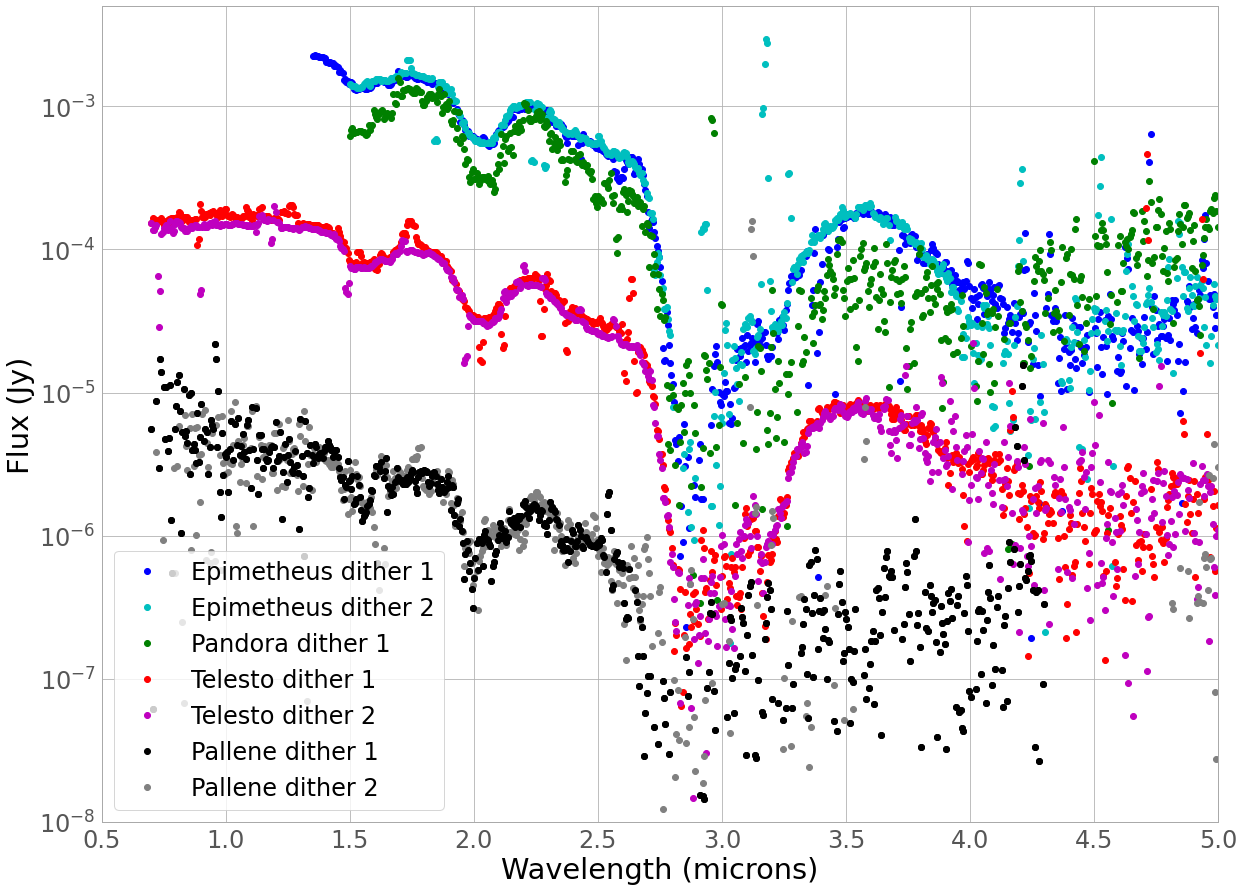

In [13]:
#Generate Figure 6

plt.figure(figsize=[20,15])
plt.rcParams['font.size'] = 24
foo=(waveep1>0.7) & (waveep1 < 5)
foox=(waveep1>1.5) & (waveep1 < 5)
fooy=(waveep1>1.35) & (waveep1 < 5)
foo2=(wavetl1>0.7)& (wavetl1 < 5)
plt.plot(waveep1[fooy],specjep1[fooy]*1e6, 'bo', label='Epimetheus dither 1')
#plt.plot(waveep1[fooy],errjep1[fooy]*1e6, 'bo', alpha=.1)
#plt.errorbar(waveep1[fooy],specjep1[fooy]*1e6,yerr=errjep1[fooy]*1e6, ls='none', color='b', alpha=.2)
plt.plot(waveep1[foox],specjep2[foox]*1e6, 'co', label='Epimetheus dither 2')
#plt.errorbar(waveep2[foox],specjep2[foox]*1e6,yerr=errjep2[foox]*1e6, ls='none', color='c', alpha=.2)

#plt.plot(waveep1[foox],specjep1[foox]*1e6, 'bo')
plt.plot(wavepd1[foox],specjpd1[foox]*1e6,'go', label='Pandora dither 1')
#plt.errorbar(wavepd1[foox],specjpd1[foox]*1e6,yerr=errjpd1[foox]*1e6, ls='none', color='g', alpha=.2)

plt.plot(wavetl1[foo2],specjtl1[foo2]*1e6,'ro', label='Telesto dither 1')
#plt.errorbar(wavetl1[foo2],specjtl1[foo2]*1e6,yerr=errjtl1[foo2]*1e6, ls='none', color='r', alpha=.2)
plt.plot(wavetl2[foo2],specjtl2[foo2]*1e6,'mo',label='Telesto dither 2')
#plt.errorbar(wavetl2[foo2],specjtl2[foo2]*1e6,yerr=errjtl2[foo2]*1e6, ls='none', color='m', alpha=.2)
plt.plot(wavepl1[foo],specjpl1[foo]*1e6,'ko',label='Pallene dither 1')
#plt.errorbar(wavepl1[foo],specjpl1[foo]*1e6,yerr=errjpl1[foo]*1e6, ls='none', color='k', alpha=.2)

plt.plot(wavepl2[foo],specjpl2[foo]*1e6,'gray',marker='o', lw=0, label='Pallene dither 2')
#plt.errorbar(wavepl2[foo],specjpl2[foo]*1e6,yerr=errjpl2[foo]*1e6, ls='none', color='gray', alpha=.2)
plt.plot(wavepl1[foo],specjpl1[foo]*1e6,'ko')
plt.yscale('log')
plt.ylabel('Flux (Jy)')
plt.ylim([1e-8,0.5e-2])
plt.xlim([.5,5])
plt.xlabel('Wavelength (microns)')
plt.legend()
plt.show()
plt.rcParams['font.size'] = 12

In [14]:
#Rotuines to extract crystalline and amorphous optical constants from Mastrapa et al. (2009) text file


def mastrapareadc(tempx): 
    f=open('Mastrapa2009.txt','r')
    header1=f.readline()
    header2=f.readline()
    header3=f.readline()
    header4=f.readline()
    header5=f.readline()
    header6=f.readline()
    header7=f.readline()
    header8=f.readline()
    header9=f.readline()
    header10=f.readline()
    header11=f.readline()
    header12=f.readline()
    header13=f.readline()
    header14=f.readline()
    header15=f.readline()
    header16=f.readline()
    wavew=[]
    nw=[]
    kw=[]
    ac=[]
    temp=[]
    #line=line.strip(',')
    #print(line)
    for line in f:
        line = line.strip()
        columns = line.split()
        if float(columns[1])==tempx and columns[0]=='Crystalline':
            ac.append(columns[0])
            temp.append(float(columns[1]))
            wavew.append(float(columns[2]))
            nw.append(float(columns[3]))
            kw.append(float(columns[4]))
    temp=np.array(temp)
    wavew=np.array(wavew)
    nw=np.array(nw)
    kw=np.array(kw)
    return wavew,nw,kw




def mastrapareada(tempx): 
    f=open('Mastrapa2009.txt','r')
    header1=f.readline()
    header2=f.readline()
    header3=f.readline()
    header4=f.readline()
    header5=f.readline()
    header6=f.readline()
    header7=f.readline()
    header8=f.readline()
    header9=f.readline()
    header10=f.readline()
    header11=f.readline()
    header12=f.readline()
    header13=f.readline()
    header14=f.readline()
    header15=f.readline()
    header16=f.readline()
    wavew=[]
    nw=[]
    kw=[]
    ac=[]
    temp=[]
    #line=line.strip(',')
    #print(line)
    for line in f:
        line = line.strip()
        columns = line.split()
        if float(columns[1])==tempx and columns[0]=='Amorphous':
            ac.append(columns[0])
            temp.append(float(columns[1]))
            wavew.append(float(columns[2]))
            nw.append(float(columns[3]))
            kw.append(float(columns[4]))
    temp=np.array(temp)
    wavew=np.array(wavew)
    nw=np.array(nw)
    kw=np.array(kw)
    return wavew,nw,kw


#Rotuine to extract Cassini-VIMS spectrum of Methone

def methoneread(): 
    f=open('methonespecplot2_tab_011224.txt','r')
    wavew=[]
    bright=[]
    err=[]
    #line=line.strip(',')
    #print(line)
    for line in f:
        line = line.strip()
        columns = line.split()
        wavew.append(float(columns[0]))
        bright.append(float(columns[1]))
        err.append(float(columns[2]))
    wavew=np.array(wavew)
    bright=np.array(bright)
    err=np.array(err)
    return wavew,bright,err

In [15]:
waveme,brightme, errme=methoneread()

In [16]:
#Rotuine to convert optical constants and scattering lengths into model albedos using Shkuratov et al. 1999 formulae


def shkalb1(wave,n,k,s):
    nnx=np.size(wave)
    theta1=np.linspace(0,np.pi/4,100)
    dtheta1=theta1[1]-theta1[0]
    theta2=theta1+np.pi/4
    alb1=np.zeros(nnx)
    for i in range(nnx):
        aS=4*np.pi*k[i]/wave[i]*s
        rs1=(np.cos(theta1)-(n[i]+k[i]*1.0j)*np.sqrt(1-np.sin(theta1)**2/n[i]**2))/(np.cos(theta1)+(n[i]+k[i]*1.0j)*np.sqrt(1-np.sin(theta1)**2/n[i]**2))
        rp1=((n[i]+k[i]*1.0j)*np.cos(theta1)-np.sqrt(1-np.sin(theta1)**2/n[i]**2))/((n[i]+k[i]*1.0j)*np.cos(theta1)+np.sqrt(1-np.sin(theta1)**2/n[i]**2))
        ro1=.5*(np.abs(rs1)**2+np.abs(rp1)**2)
        rb=np.sum(2*ro1*np.cos(theta2)*np.sin(theta2))*dtheta1
        rs2=(np.cos(theta2[np.sin(theta2)<n[i]])-(n[i]+k[i]*1.0j)*np.sqrt(1-np.sin(theta2[np.sin(theta2)<n[i]])**2/n[i]**2))/(np.cos(theta2[np.sin(theta2)<n[i]])+(n[i]+k[i]*1.0j)*np.sqrt(1-np.sin(theta2[np.sin(theta2)<n[i]])**2/n[i]**2))
        rp2=((n[i]+k[i]*1.0j)*np.cos(theta2[np.sin(theta2)<n[i]])-np.sqrt(1-np.sin(theta2[np.sin(theta2)<n[i]])**2/n[i]**2))/((n[i]+k[i]*1.0j)*np.cos(theta2[np.sin(theta2)<n[i]])+np.sqrt(1-np.sin(theta2[np.sin(theta2)<n[i]])**2/n[i]**2))
        ro2=.5*(np.abs(rs2)**2+np.abs(rp2)**2)
        rf=np.sum(2*ro2*np.cos(theta2[np.sin(theta2)<n[i]])*np.sin(theta2[np.sin(theta2)<n[i]]))*dtheta1
        re=rb+rf
        ri=1-(1-re)/n[i]**2
        rrb=rb+0.5*(1-re)*(1-ri)*ri*np.exp(-2*aS)/(1-ri*np.exp(-aS))
        rrf=rf+(1-re)*(1-ri)*np.exp(-aS)+0.5*(1-re)*(1-ri)*ri*np.exp(-2*aS)/(1-ri*np.exp(-aS))
        alb1[i]=(1+rrb**2-rrf**2)/2/rrb-np.sqrt((1+rrb**2-rrf**2)**2/4/rrb**2-1)
    return alb1

In [17]:
wavec,nc,kc=mastrapareadc(100)
wavea,na,ka=mastrapareada(100)
alba=shkalb1(wavea,na,ka,10)
albc=shkalb1(wavec,nc,kc,10)

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/1734933386.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/1734933386.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/1734933386.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/1734933386.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/1734933386.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4

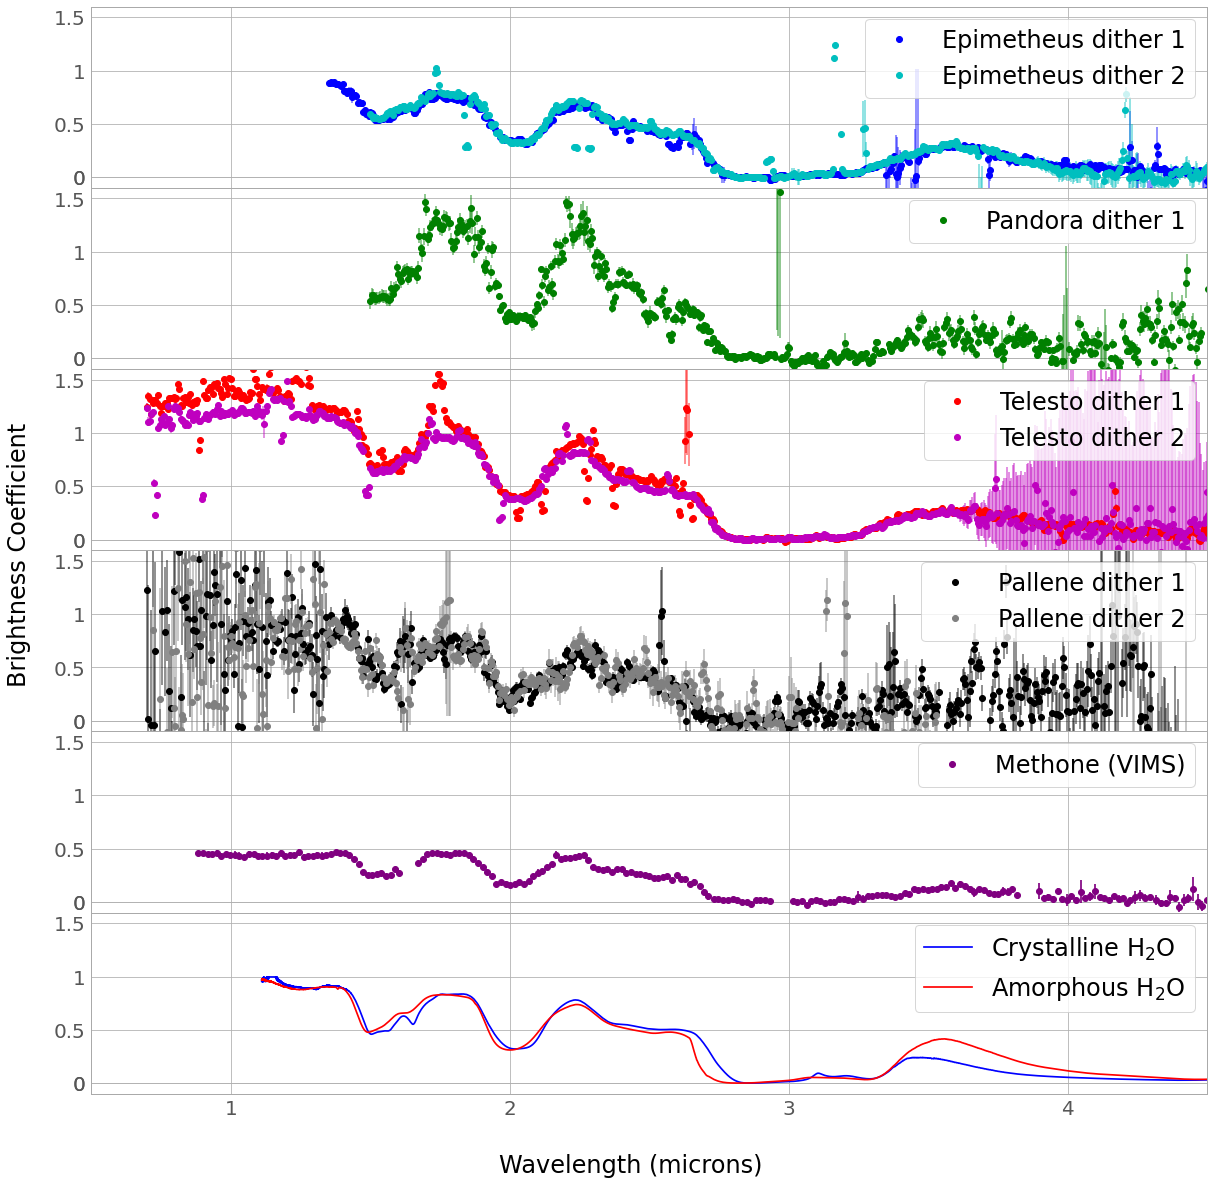

In [18]:
#Generate Figure 7 of paper

fig=plt.figure(figsize=[20,20])
gs = fig.add_gridspec(6, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
axs[1].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
axs[2].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
axs[3].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
axs[4].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
axs[5].set_yticklabels([0,0,.5,1,1.5],fontsize=20)
axs[0].set_yticks([0,0,.5,1,1.5])
axs[1].set_yticks([0,0,.5,1,1.5])
axs[2].set_yticks([0,0,.5,1,1.5])
axs[3].set_yticks([0,0,.5,1,1.5])
axs[4].set_yticks([0,0,.5,1,1.5])
axs[5].set_yticks([0,0,.5,1,1.5])
axs[5].set_xticklabels([1,2,3,4],fontsize=20)
axs[5].set_xticks([1,2,3,4])

plt.rcParams['font.size'] = 24
fooep1=(waveep1>1.35) & (waveep1 < 5)
fooep2=(waveep1>1.5) & (waveep1 < 5)
foopd=(wavepd1>1.5) & (wavepd1 < 5)
footl=(wavetl1>1.3)& (wavetl1 < 5)
foopl=(wavepl1>1.3)& (wavepl1 < 5)
footl=(wavetl1>0.7)& (wavetl1 < 5)
foopl=(wavepl1>0.7)& (wavepl1 < 5)
foome=(np.abs(waveme-waveme[46])>.03) & (np.abs(waveme-waveme[127])>.03) & (np.abs(waveme-waveme[180])>.03)


axs[0].plot(waveep1[fooep1],specep1[fooep1], 'bo', label='Epimetheus dither 1')
axs[0].errorbar(waveep1[fooep1],specep1[fooep1], yerr=errep1[fooep1],ls='none', color='b', alpha=.5)
axs[0].plot(waveep1[fooep2],specep2[fooep2], 'co',label='Epimetheus dither 2')
axs[0].errorbar(waveep1[fooep2],specep2[fooep2], yerr=errep2[fooep2],ls='none', color='c', alpha=.5)

axs[0].legend(loc='upper right')

axs[1].plot(wavepd1[foopd],specpd1[foopd],'go', label='Pandora dither 1')
axs[1].errorbar(wavepd1[foopd],specpd1[foopd], yerr=errpd1[foopd],ls='none', color='g', alpha=.5)

axs[1].legend(loc='upper right')


axs[2].plot(wavetl1[footl],spectl1[footl],'ro', label='Telesto dither 1')
axs[2].errorbar(wavetl1[footl],spectl1[footl], yerr=errtl1[footl],ls='none', color='r', alpha=.5)
axs[2].plot(wavetl2[footl],spectl2[footl],'mo', label='Telesto dither 2')
axs[2].errorbar(wavetl2[footl],spectl2[footl], yerr=errtl2[footl],ls='none', color='m', alpha=.5)
axs[2].legend(loc='upper right')

axs[3].plot(wavepl1[foopl],specpl1[foopl],'ko',label='Pallene dither 1')
axs[3].errorbar(wavepl1[foopl],specpl1[foopl], yerr=errpl1[foopl],ls='none', color='k', alpha=.5)
axs[3].plot(wavepl2[foopl],specpl2[foopl],'gray',marker='o', lw=0,label='Pallene dither 2')
axs[3].errorbar(wavepl2[foopl],specpl2[foopl], yerr=errpl2[foopl],ls='none', color='gray', alpha=.5)
axs[3].legend(loc='upper right')

axs[4].plot(waveme[foome], brightme[foome],'purple',marker='o', lw=0,label='Methone (VIMS)')
axs[4].errorbar(waveme[foome], brightme[foome],yerr=errme[foome], ls='none', color='purple')

axs[4].legend(loc='upper right')
axs[5].plot(wavec,albc,'b',label='Crystalline H$_2$O')
axs[5].plot(wavea,alba,'r',label='Amorphous H$_2$O')
axs[5].legend(loc='upper right')
plt.ylim([-.1,1.6])
plt.xlim([0.5,4.5])
#plt.xlim([1.6,2.4])
#plt.xscale('log')
#plt.xlabel('Wavelength (microns)')
#plt.ylabel('Brightness Coefficient')
fig.text(0.075, 0.5, 'Brightness Coefficient', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.075, 'Wavelength (microns)', ha='center', va='center')

#plt.legend()
plt.show()
plt.rcParams['font.size'] = 12

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/2925895481.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0,0,.05,.1],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/2925895481.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0,0,.05,.1],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/2925895481.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels([0,0,.05,.1],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/2925895481.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels([2.8,3.0,3.2],fontsize=20)


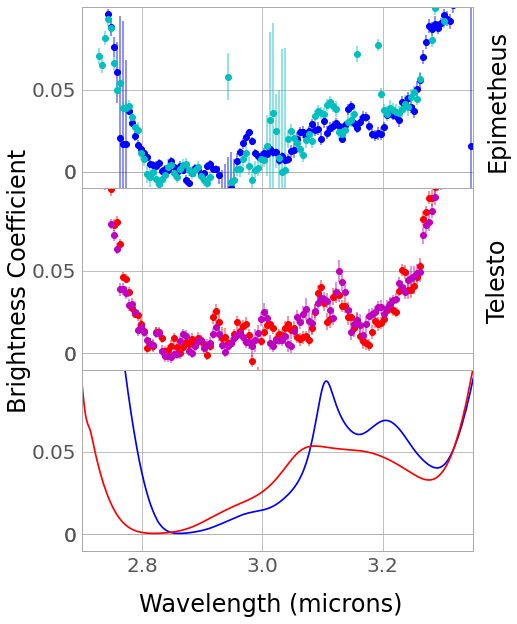

In [19]:
#Generate Figure 8 of paper

fig=plt.figure(figsize=[7,10])
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].set_yticklabels([0,0,.05,.1],fontsize=20)
axs[1].set_yticklabels([0,0,.05,.1],fontsize=20)
axs[2].set_yticklabels([0,0,.05,.1],fontsize=20)
axs[2].set_xticklabels([2.8,3.0,3.2],fontsize=20)
axs[2].set_xticks([2.8,3,3.2])
axs[0].set_yticks([0,0,.05,1])
axs[1].set_yticks([0,0,.05,1])
axs[2].set_yticks([0,0,.05,1])

plt.rcParams['font.size'] = 24
fooep1=(waveep1>1.35) & (waveep1 < 5)
fooep2=(waveep1>1.5) & (waveep1 < 5)
foopd=(wavepd1>1.5) & (wavepd1 < 5)
footl=(wavetl1>1.3)& (wavetl1 < 5)
foopl=(wavepl1>1.3)& (wavepl1 < 5)
footl=(wavetl1>0.7)& (wavetl1 < 5)
foopl=(wavepl1>0.7)& (wavepl1 < 5)


#axs[0].plot(waveep1[fooep1],specep1[fooep1], 'bo', label='Epimetheus dither 1')
#axs[0].plot(waveep1[fooep2],specep2[fooep2], 'co',label='Epimetheus dither 2')
axs[0].plot(waveep1[fooep1],specep1[fooep1], 'bo', label='Epimetheus dither 1')
axs[0].errorbar(waveep1[fooep1],specep1[fooep1], yerr=errep1[fooep1],ls='none', color='b', alpha=.5)
axs[0].plot(waveep1[fooep2],specep2[fooep2], 'co',label='Epimetheus dither 2')
axs[0].errorbar(waveep1[fooep2],specep2[fooep2], yerr=errep2[fooep2],ls='none', color='c', alpha=.5)

#axs[0].legend(loc='upper right')

#axs[1].plot(wavepd1[foopd],specpd1[foopd],'go', label='Pandora dither 1')
#axs[1].legend(loc='upper right')
#axs[1].plot(wavetl1[footl],spectl1[footl],'ro', label='Telesto dither 1')
#axs[1].plot(wavetl2[footl],spectl2[footl],'mo', label='Telesto dither 2')

axs[1].plot(wavetl1[footl],spectl1[footl],'ro', label='Telesto dither 1')
axs[1].errorbar(wavetl1[footl],spectl1[footl], yerr=errtl1[footl],ls='none', color='r', alpha=.5)
axs[1].plot(wavetl2[footl],spectl2[footl],'mo', label='Telesto dither 2')
axs[1].errorbar(wavetl2[footl],spectl2[footl], yerr=errtl2[footl],ls='none', color='m', alpha=.5)

#axs[2].legend(loc='upper right')
#axs[3].plot(wavepl1[foopl],specpl1[foopl],'ko',label='Pallene dither 1')
#axs[3].plot(wavepl2[foopl],specpl2[foopl],'gray',marker='o', lw=0,label='Pallene dither 2')
#axs[3].legend(loc='upper right')
#axs[3].plot(wavepl1[foopl],specpl1[foopl],'ko')
axs[2].plot(wavec,albc,'b',label='Crystalline H$_2$O')
axs[2].plot(wavea,alba,'r',label='Amorphous H$_2$O')
#axs[2].legend(loc='upper right')
plt.ylim([-.01,0.1])
plt.xlim([2.7,3.35])
#plt.xscale('log')
#plt.xlabel('Wavelength (microns)')
#plt.ylabel('Brightness Coefficient')
fig.text(0., 0.5, 'Brightness Coefficient', ha='center', va='center', rotation='vertical')
fig.text(0.95, 0.75, 'Epimetheus', ha='center', va='center', rotation='vertical')
fig.text(0.95, 0.5, 'Telesto', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Wavelength (microns)', ha='center', va='center')

#plt.legend()
plt.show()
plt.rcParams['font.size'] = 12

/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/3572719278.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0,0,.5,1],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/3572719278.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0,0,.5,1],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/3572719278.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels([0,0,.5,1],fontsize=20)
/var/folders/lj/3p5r7psn5czdlfnyz_18s59h0000gn/T/ipykernel_4545/3572719278.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels([1.4,1.6,1.8],fontsize=20)


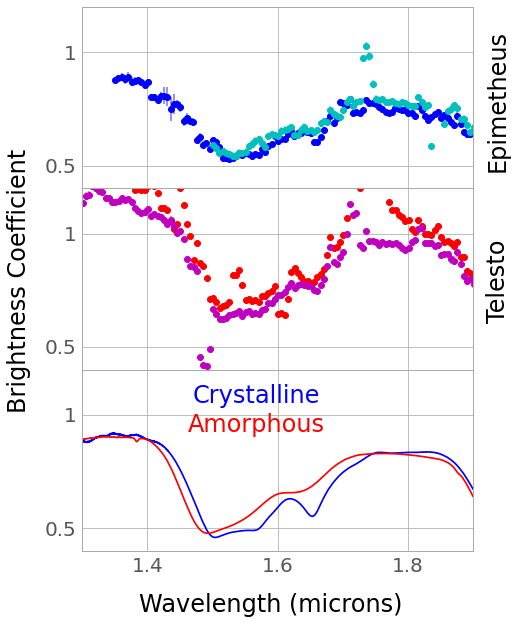

In [20]:
fig=plt.figure(figsize=[7,10])
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].set_yticklabels([0,0,.5,1],fontsize=20)
axs[1].set_yticklabels([0,0,.5,1],fontsize=20)
axs[2].set_yticklabels([0,0,.5,1],fontsize=20)
axs[2].set_xticklabels([1.4,1.6,1.8],fontsize=20)
axs[2].set_xticks([1.4,1.6,1.8])
axs[0].set_yticks([0,0,.5,1])
axs[1].set_yticks([0,0,.5,1])
axs[2].set_yticks([0,0,.5,1])

plt.rcParams['font.size'] = 24
fooep1=(waveep1>1.35) & (waveep1 < 5)
fooep2=(waveep1>1.5) & (waveep1 < 5)
foopd=(wavepd1>1.5) & (wavepd1 < 5)
footl=(wavetl1>1.3)& (wavetl1 < 5)
foopl=(wavepl1>1.3)& (wavepl1 < 5)
footl=(wavetl1>0.7)& (wavetl1 < 5)
foopl=(wavepl1>0.7)& (wavepl1 < 5)

axs[0].plot(waveep1[fooep1],specep1[fooep1], 'bo', label='Epimetheus dither 1')
axs[0].errorbar(waveep1[fooep1],specep1[fooep1], yerr=errep1[fooep1],ls='none', color='b', alpha=.5)
axs[0].plot(waveep1[fooep2],specep2[fooep2], 'co',label='Epimetheus dither 2')
axs[0].errorbar(waveep1[fooep2],specep2[fooep2], yerr=errep2[fooep2],ls='none', color='c', alpha=.5)

#axs[0].plot(waveep1[fooep1],specep1[fooep1], 'bo', label='Epimetheus dither 1')
#axs[0].plot(waveep1[fooep2],specep2[fooep2], 'co',label='Epimetheus dither 2')

#axs[0].legend(loc='upper right')

#axs[1].plot(wavepd1[foopd],specpd1[foopd],'go', label='Pandora dither 1')
#axs[1].legend(loc='upper right')
#axs[1].plot(wavetl1[footl],spectl1[footl],'ro', label='Telesto dither 1')
#axs[1].plot(wavetl2[footl],spectl2[footl],'mo', label='Telesto dither 2')

axs[1].plot(wavetl1[footl],spectl1[footl],'ro', label='Telesto dither 1')
axs[1].errorbar(wavetl1[footl],spectl1[footl], yerr=errtl1[footl],ls='none', color='r', alpha=.5)
axs[1].plot(wavetl2[footl],spectl2[footl],'mo', label='Telesto dither 2')
axs[1].errorbar(wavetl2[footl],spectl2[footl], yerr=errtl2[footl],ls='none', color='m', alpha=.5)

#axs[2].legend(loc='upper right')
#axs[3].plot(wavepl1[foopl],specpl1[foopl],'ko',label='Pallene dither 1')
#axs[3].plot(wavepl2[foopl],specpl2[foopl],'gray',marker='o', lw=0,label='Pallene dither 2')
#axs[3].legend(loc='upper right')
#axs[3].plot(wavepl1[foopl],specpl1[foopl],'ko')
axs[2].plot(wavec,albc,'b',label='Crystalline H$_2$O')
axs[2].plot(wavea,alba,'r',label='Amorphous H$_2$O')
#axs[2].legend()
plt.ylim([0.4,1.2])
plt.xlim([1.3,1.9])
#plt.xscale('log')
#plt.xlabel('Wavelength (microns)')
#plt.ylabel('Brightness Coefficient')
fig.text(0., 0.5, 'Brightness Coefficient', ha='center', va='center', rotation='vertical')
fig.text(0.95, 0.75, 'Epimetheus', ha='center', va='center', rotation='vertical')
fig.text(0.95, 0.5, 'Telesto', ha='center', va='center', rotation='vertical')
fig.text(0.47, 0.34, 'Crystalline', ha='center', va='center', color='blue')
fig.text(0.47, 0.30, 'Amorphous', ha='center', va='center', color='red')
fig.text(0.5, 0.05, 'Wavelength (microns)', ha='center', va='center')

#plt.legend()
plt.show()
plt.rcParams['font.size'] = 12

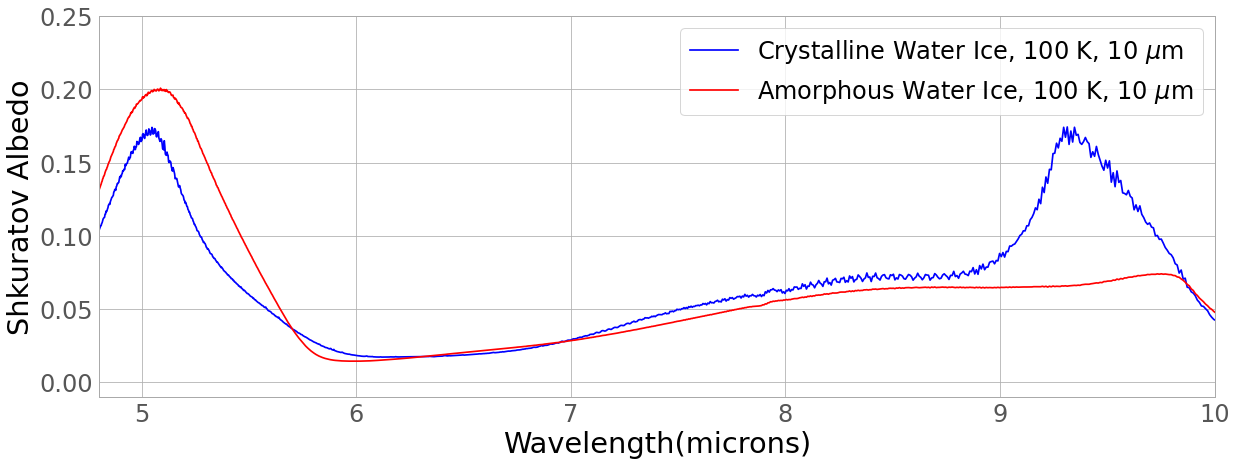

In [21]:
#Generate bottom panel of Figure 14

plt.figure(figsize=[20,7])
plt.rcParams['font.size'] = 24
#plt.plot(wavep2,specr2/solflux/(.5/3600*np.pi/180)**2*50-.15)
#plt.plot(wavep2[foo],specrx[foo], 'b')
#plt.title('Spectra')
plt.ylabel('Shkuratov Albedo')
plt.xlabel('Wavelength(microns)')
plt.ylim([-.01,.25])
plt.plot(wavec,albc, 'b', label='Crystalline Water Ice, 100 K, 10 $\mu$m')
plt.plot(wavea,alba,'r', label='Amorphous Water Ice, 100 K, 10 $\mu$m')
plt.xlim([4.8,10])
plt.legend()
plt.show()

plt.rcParams['font.size'] = 12

In [22]:
#Save the moon spectra to csv files

foo=(waveep1>0.7) & (waveep1 < 5)
foox=(waveep1>1.5) & (waveep1 < 5)
fooy=(waveep1>1.35) & (waveep1 < 5)
foo2=(wavetl1>0.7)& (wavetl1 < 5)
waveep1x=waveep1[fooy]
specjep1x=specjep1[fooy]*1e6
errjep1x=errjep1[fooy]*1e6
waveep2x=waveep1[foox]
specjep2x=specjep2[foox]*1e6
errjep2x=errjep2[foox]*1e6
wavepd1x=wavepd1[foox]
specjpd1x=specjpd1[foox]*1e6
errjpd1x=errjpd1[foox]*1e6
wavetl1x=wavetl1[foo2]
specjtl1x=specjtl1[foo2]*1e6
specjtl2x=specjtl2[foo2]*1e6
errjtl1x=errjtl1[foo2]*1e6
errjtl2x=errjtl2[foo2]*1e6
wavepl1x=wavepl1[foo]
specjpl1x=specjpl1[foo]*1e6
specjpl2x=specjpl2[foo]*1e6
errjpl1x=errjpl1[foo]*1e6
errjpl2x=errjpl2[foo]*1e6

import csv
with open('JW1247_NIRSpec_Epimetheusflux_dither1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(waveep1x)):
        writer.writerow([waveep1x[i]]+[specjep1x[i]]+[errjep1x[i]])
with open('JW1247_NIRSpec_Epimetheusflux_dither2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(waveep2x)):
        writer.writerow([waveep2x[i]]+[specjep2x[i]]+[errjep2x[i]])
with open('JW1247_NIRSpec_Pandoraflux_dither1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(wavepd1x)):
        writer.writerow([wavepd1x[i]]+[specjpd1x[i]]+[errjpd1x[i]])
with open('JW1247_NIRSpec_Telestoflux_dither1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(wavetl1x)):
        writer.writerow([wavetl1x[i]]+[specjtl1x[i]]+[errjtl1x[i]])
with open('JW1247_NIRSpec_Telestoflux_dither2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(wavetl1x)):
        writer.writerow([wavetl1x[i]]+[specjtl2x[i]]+[errjtl2x[i]])
with open('JW1247_NIRSpec_Palleneflux_dither1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(wavepl1x)):
        writer.writerow([wavepl1x[i]]+[specjpl1x[i]]+[errjpl1x[i]])
with open('JW1247_NIRSpec_Palleneflux_dither2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Wavelength'] + ['Flux (Jy)'] + ['Error (Jy)'])
    for i in range(len(wavepl1x)):
        writer.writerow([wavepl1x[i]]+[specjpl2x[i]]+[errjpl2x[i]])